In [1]:
from sklearn import svm
from sklearn import linear_model
import datetime
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import math
import joblib
import copy
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima_model import ARIMA
from genetic_selection import GeneticSelectionCV

# Read FRED data
djia_stat = {}
news_stat = {}
djia_st = 0

start_date = (datetime.datetime.strptime("2018-11-09", "%Y-%m-%d") - datetime.datetime(1970, 1, 1)).total_seconds()

with open("DJIA.csv", "r") as djia_r:
    djia_r.readline()
    djia_close = []
    for l in djia_r:
        x = l.strip().split(",")
        if x[1] == ".": # Skip days for which there are no values.
            continue
        u = [(datetime.datetime.strptime(x[0], "%Y-%m-%d") - datetime.datetime(1970, 1, 1)).total_seconds(), djia_close[-1] if len(djia_close) != 0 else float(x[1]), djia_close[-2] if len(djia_close) > 1 else float(x[1])]
        if x[0] == "2018-11-09": # Check this date
            djia_st = len(djia_stat)
        v = float(x[1]) # Output value
        djia_close.append(v)
        djia_stat[u[0]] = u[1:] + [v]

with open("DJIAHeadlines.csv", "r") as headlines_r:
    for l in headlines_r:
        vals = l.split(",")
        news_stat[(datetime.datetime.strptime(vals[0], "%Y-%m-%d") - datetime.datetime(1970, 1, 1)).total_seconds()] = [int(x) for x in vals[1:]]

# Toss out any data before start_date
ks = copy.deepcopy(list(djia_stat.keys()))
for k in ks:
    if k < start_date:
        del djia_stat[k]
    
# Assume these will both be arrays.
def dict_zip(djia, other):
    k = djia.keys() # Only use DJIA keys as it is closed more often than the news
    res = []
    for x in k:
        if x not in other.keys():
            continue
        res.append([x] + other[x] + djia[x])
    return res
        
def fit(djia_s):
    djia_in = []
    djia_out = []
    dat_ = djia_s
    dat = []
    
    dat = dat_
    split = int(.8 * len(dat))

    scaler = MinMaxScaler()
    scaler.fit(dat)
    djia_s = scaler.transform(dat)
    
    djia_in = [x[:-1] for x in djia_s]
    djia_out = [x[-1] for x in djia_s]

    djia_in_train = np.array(djia_in[:split])
    djia_out_train = np.array(djia_out[:split])
    djia_in_test = np.array(djia_in[split:])
    djia_out_test = np.array(djia_out[split:])

    m = svm.SVR(C=0.01, cache_size=1000, coef0=djia_out_train[-1], degree=5, epsilon=0.001, gamma='auto', kernel='poly', max_iter=5000, shrinking=True, tol=0.0001, verbose=True)

    model = m.fit(djia_in_train, djia_out_train)
    res = copy.deepcopy(m.predict(djia_in_test))

    m2 = GeneticSelectionCV(m, cv=5, verbose=1, scoring="neg_mean_squared_error", n_population=1000, crossover_proba=0.5, mutation_proba=0.2, n_generations=3000, crossover_independent_proba=0.5, mutation_independent_proba=0.05, tournament_size=3, n_gen_no_change=10, caching=True, n_jobs=10)
    m2.fit(djia_in_train, djia_out_train)

    res2 = m2.predict(djia_in_test)
    
    mk = KernelRidge(alpha=1)
    mk.fit(djia_in_train, djia_out_train)
    res_mk = mk.predict(djia_in_test)
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(1, len(res)):
        dirres = res[i] - res[i - 1] >= 0
        diract = djia_out_test[i] - djia_out_test[i - 1] >= 0
        if dirres == diract:
            if dirres == True:
                tp += 1
            else:
                tn += 1
        else:
            if dirres == True:
                fp += 1
            else:
                fn += 1

    return (split, djia_out_test, res, res2, res_mk)

c:\users\bcwarner\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 600

[LibSVM]Selecting features with genetic algorithm.
gen	nevals	avg                          	std                            	min              	max                      
0  	1000  	[-250.01939768    2.951     ]	[1.56124639e+03 1.25163853e+00]	[-10000.      0.]	[-0.00860168  6.        ]
1  	581   	[-30.01312288   2.993     ]  	[546.89963673   1.08763551]    	[-10000.      0.]	[-0.00860168  6.        ]
2  	599   	[-30.01048207   2.632     ]  	[546.89978157   1.00924526]    	[-10000.      0.]	[-0.00860168  6.        ]
3  	567   	[-20.0094927   2.089    ]    	[446.76573313   0.87468794]    	[-10000.      0.]	[-0.00860168  5.        ]
4  	605   	[-50.00894653   1.495     ]  	[7.05336165e+02 6.63306113e-01]	[-10000.      0.]	[-0.00860168  4.        ]
5  	631   	[-70.0087627   1.121    ]    	[8.33725838e+02 3.77304916e-01]	[-10000.      0.]	[-0.00860168  3.        ]
6  	578   	[-30.0086987   1.047    ]    	[5.46899879e+02 2.62280384e-01]	[-10000.      0.]	[-0.00860168  4.        ]
7  	578   	[-

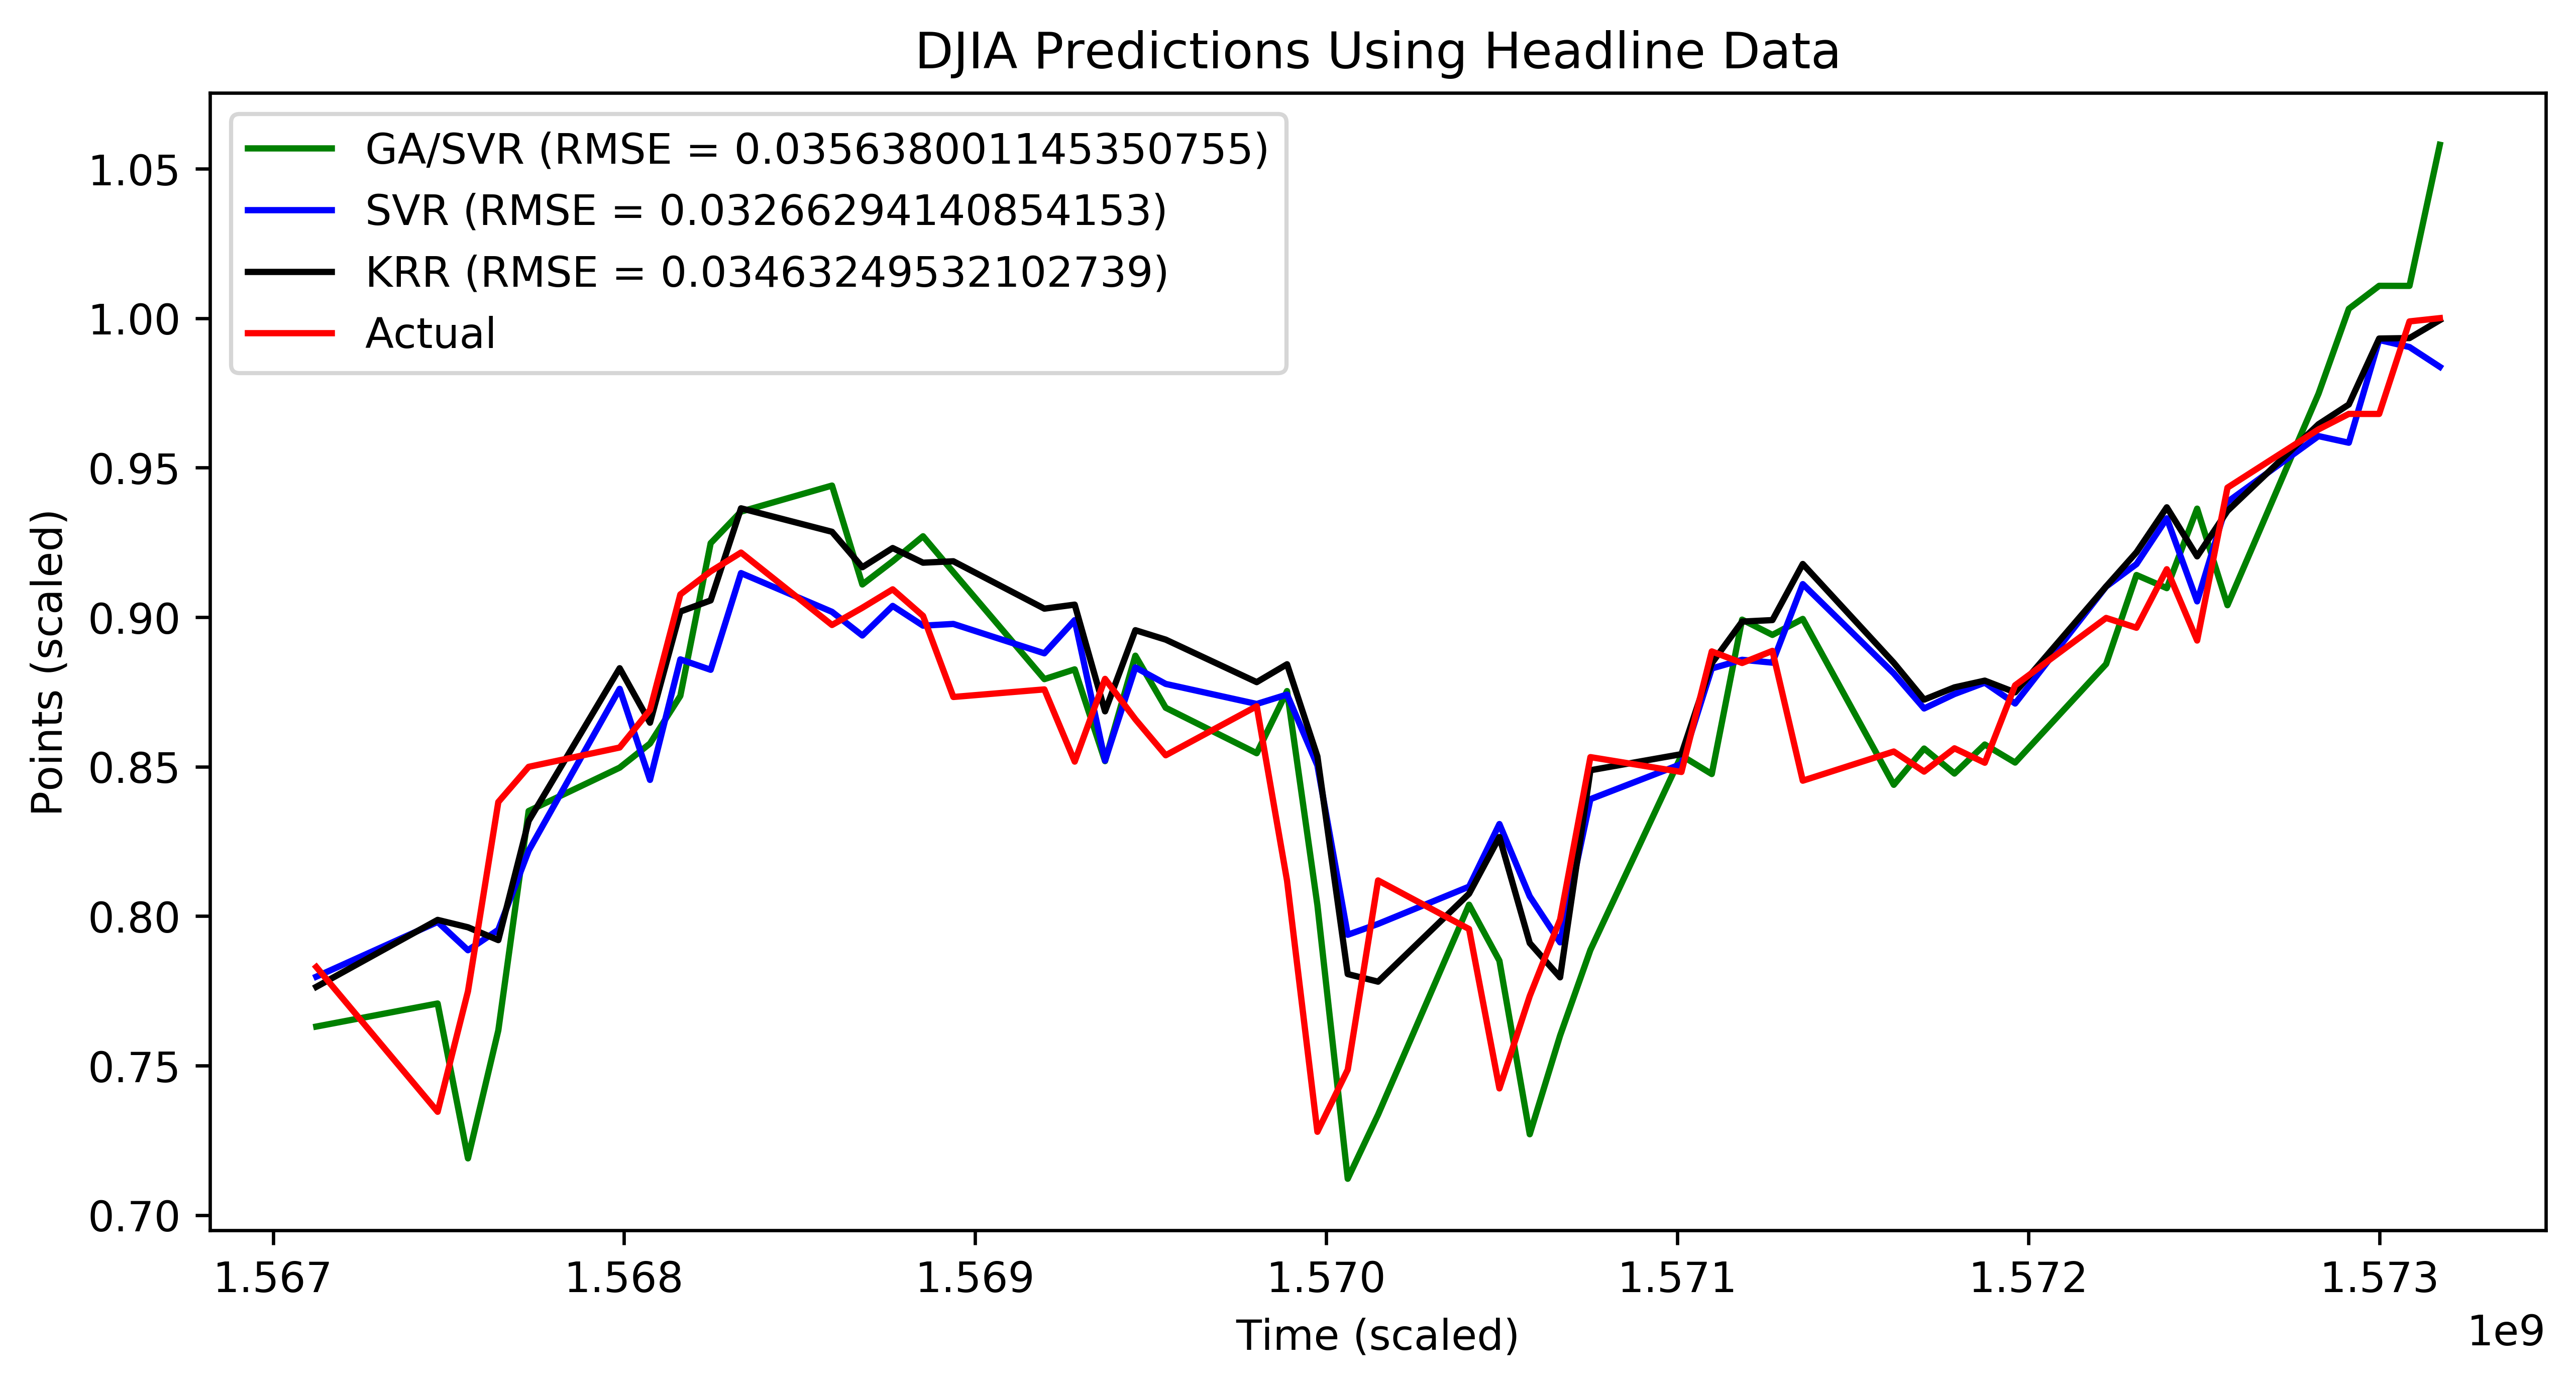

In [3]:
inp = dict_zip(djia_stat, news_stat)
split, actual, res, resga, res_mk = fit(inp)
xs = [x[0] for x in inp[split:]]
plt.plot(xs, resga, "g", label="GA/SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, resga))) + ")")
plt.plot(xs, res, "b", label="SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res))) + ")")
plt.plot(xs, res_mk, "k", label="KRR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res_mk))) + ")")
plt.plot(xs, actual, "r", label="Actual")
plt.title("DJIA Predictions Using Headline Data")
plt.xlabel('Time (scaled)')
plt.ylabel('Points (scaled)')
plt.legend()

[LibSVM]Selecting features with genetic algorithm.
gen	nevals	avg                          	std                            	min              	max                      
0  	1000  	[-380.01693942    2.467     ]	[1.91195898e+03 1.13353915e+00]	[-10000.      0.]	[-0.00860168  5.        ]
1  	577   	[-110.01134189    2.656     ]	[1043.02325229    1.06191525]  	[-10000.      0.]	[-0.00860168  5.        ]
2  	575   	[-30.00963393   2.348     ]  	[546.89982809   0.95963326]    	[-10000.      0.]	[-0.00860168  5.        ]
3  	595   	[-40.00910892   1.83      ]  	[631.18877627   0.86666026]    	[-10000.      0.]	[-0.00860168  4.        ]
4  	599   	[-50.00875586   1.335     ]  	[7.05336178e+02 6.65413405e-01]	[-10000.      0.]	[-0.00860168  4.        ]
5  	609   	[-170.00854172    1.047     ]	[1.29270921e+03 3.26788923e-01]	[-10000.      0.]	[-0.00860168  3.        ]
6  	601   	[-90.00864506   1.042     ]  	[9.44403750e+02 2.49471441e-01]	[-10000.      0.]	[-0.00860168  3.        ]
7  	613   	[-

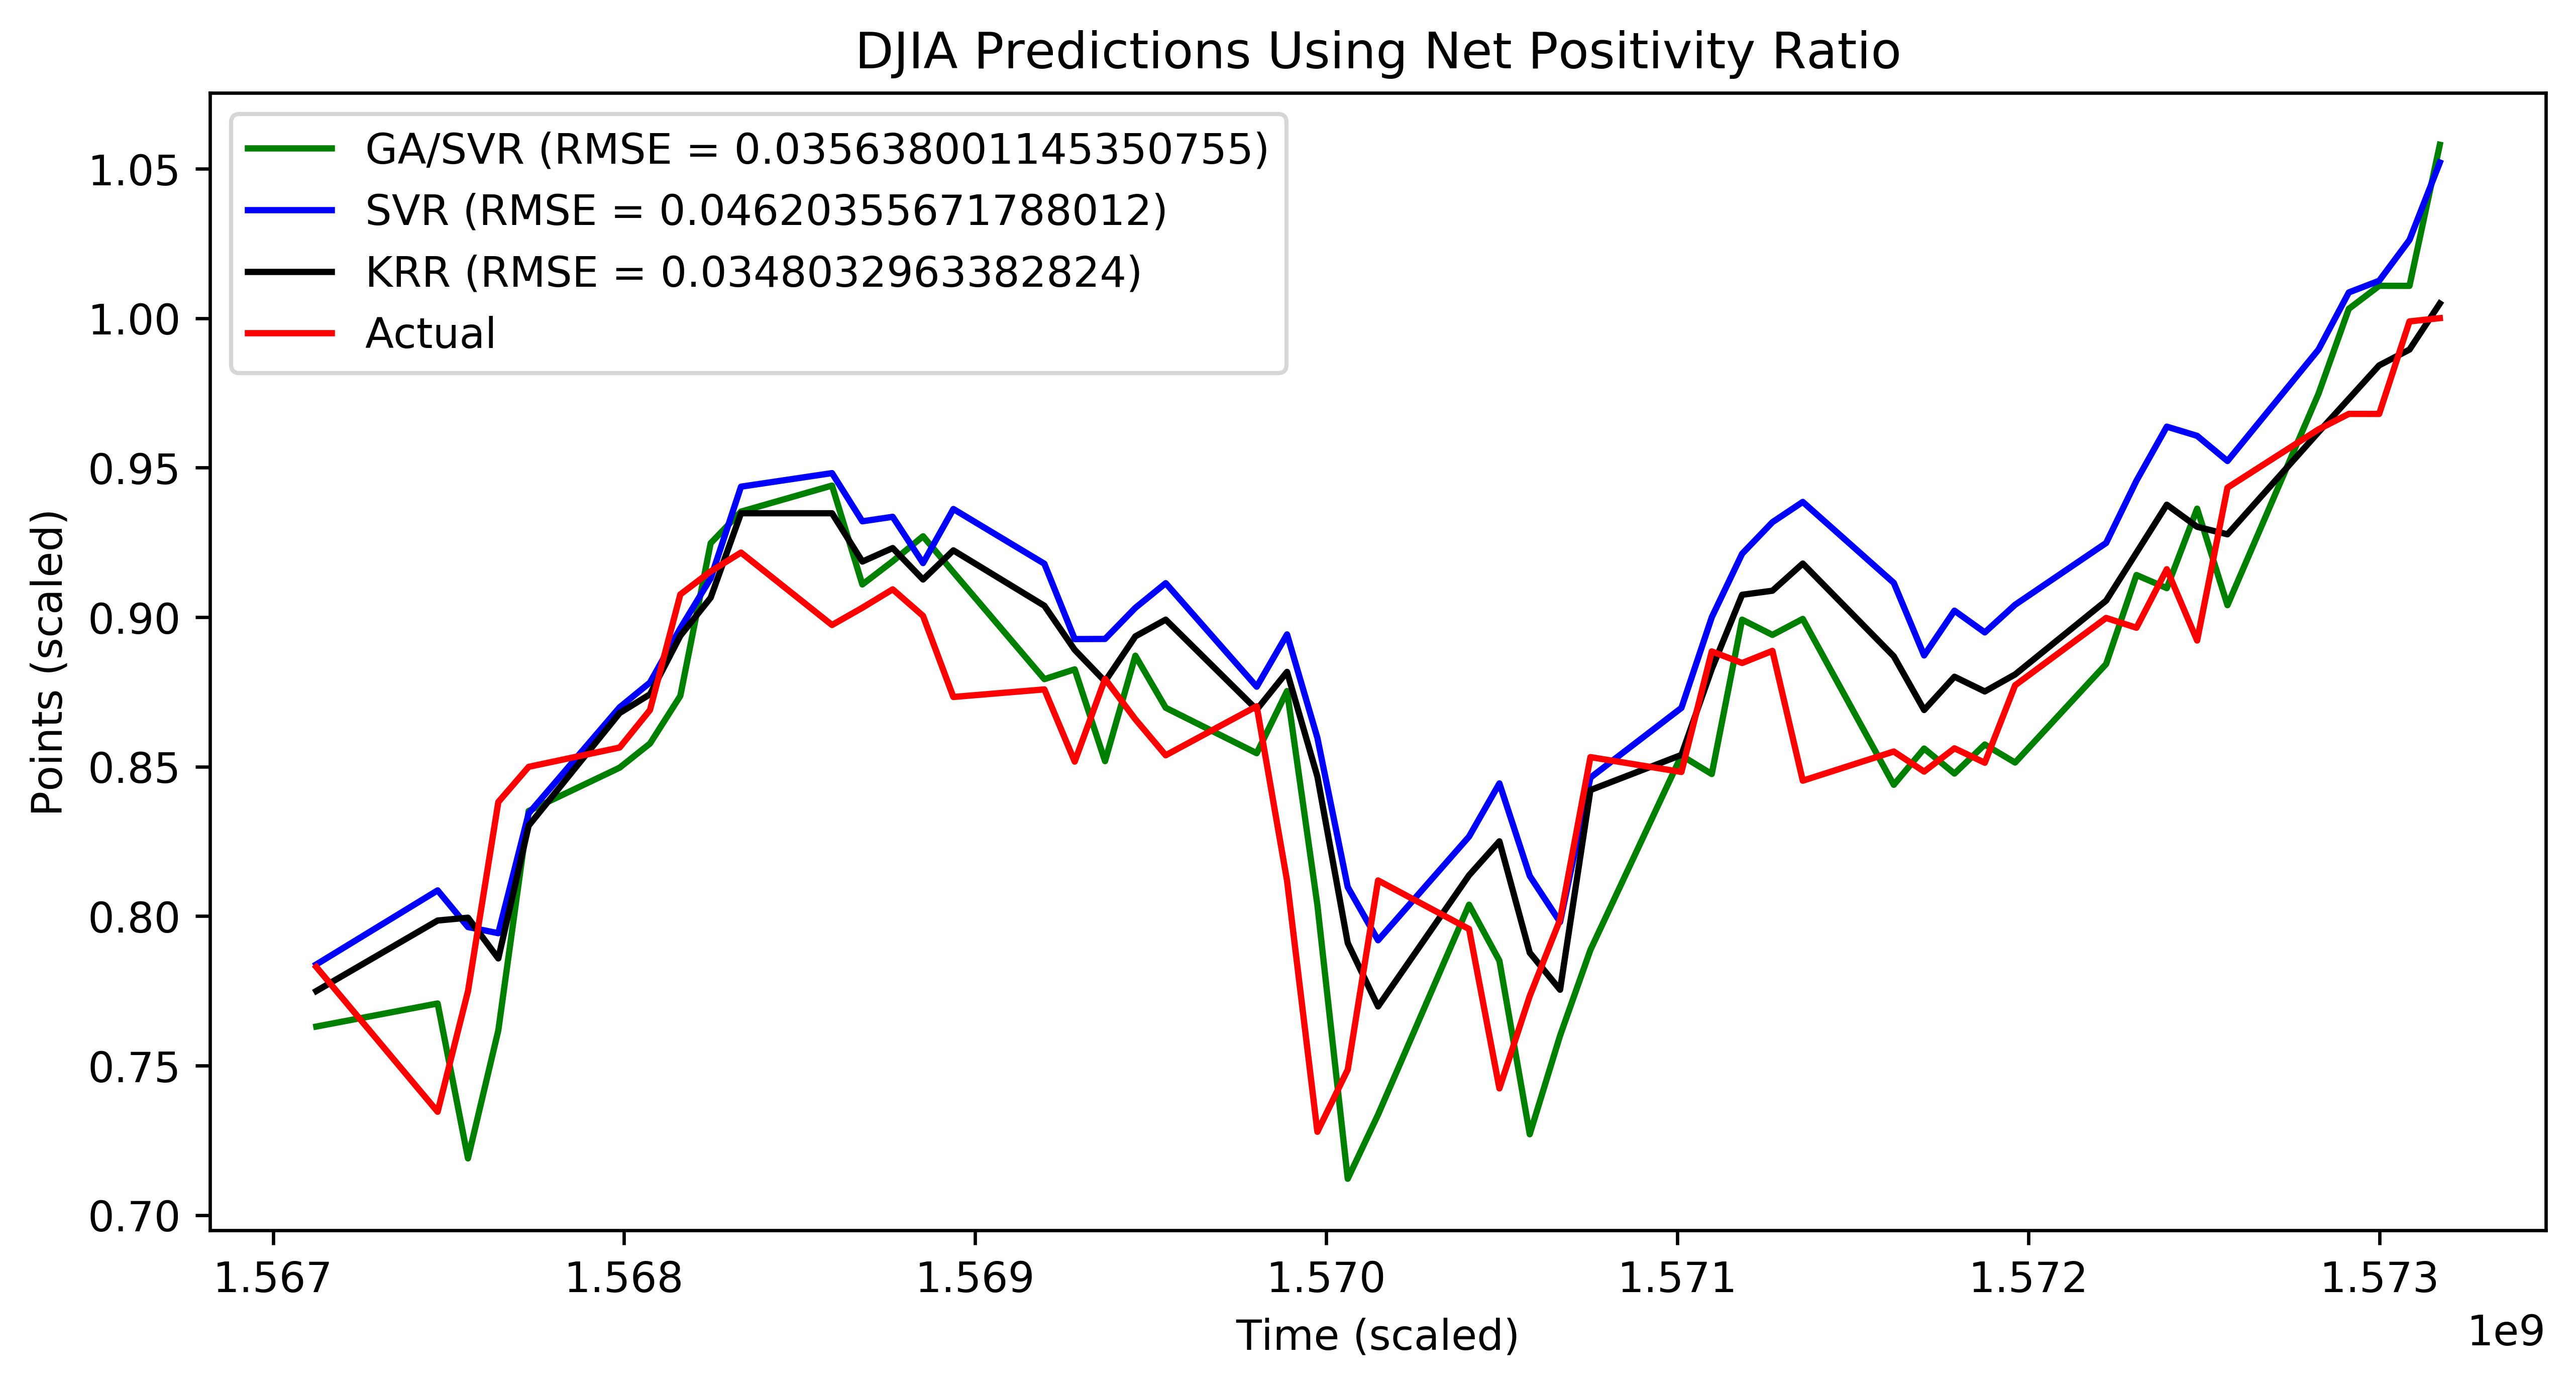

In [4]:
news_stat_ratio = {}
for k, v in news_stat.items():
    news_stat_ratio[k] = [news_stat[k][0],  (news_stat[k][1] - news_stat[k][2]) / (news_stat[k][0])]
    
inp2 = dict_zip(djia_stat, news_stat_ratio)
split, actual, res2, resga2, res_mk2 = fit(inp2)
xs = [x[0] for x in inp2[split:]]
plt.plot(xs, resga2, "g", label="GA/SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, resga2))) + ")")
plt.plot(xs, res2, "b", label="SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res2))) + ")")
plt.plot(xs, res_mk2, "k", label="KRR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res_mk2))) + ")")
plt.plot(xs, actual, "r", label="Actual")
plt.title("DJIA Predictions Using Net Positivity Ratio")
plt.xlabel('Time (scaled)')
plt.ylabel('Points (scaled)')
plt.legend()
plt.show()

[LibSVM]Selecting features with genetic algorithm.
gen	nevals	avg                          	std                            	min              	max                      
0  	1000  	[-280.01679442    2.509     ]	[1.64972440e+03 1.09358082e+00]	[-10000.      0.]	[-0.00860168  5.        ]
1  	606   	[-30.01138638   2.756     ]  	[546.89973198   1.00521838]    	[-10000.      0.]	[-0.00860168  5.        ]
2  	622   	[-40.00970942   2.547     ]  	[631.18873821   0.90321149]    	[-10000.      0.]	[-0.00860168  5.        ]
3  	616   	[-10.00927008   2.221     ]  	[316.06931929   0.83555909]    	[-10000.      0.]	[-0.00860168  4.        ]
4  	603   	[-20.00907033   1.887     ]  	[446.76575203   0.91445667]    	[-10000.      0.]	[-0.00860168  4.        ]
5  	613   	[-70.00877341   1.295     ]  	[8.33725837e+02 6.61796797e-01]	[-10000.      0.]	[-0.00860168  4.        ]
6  	608   	[-100.00860447    1.04      ]	[9.94986572e+02 2.76405499e-01]	[-10000.      0.]	[-0.00860168  3.        ]
7  	593   	[-

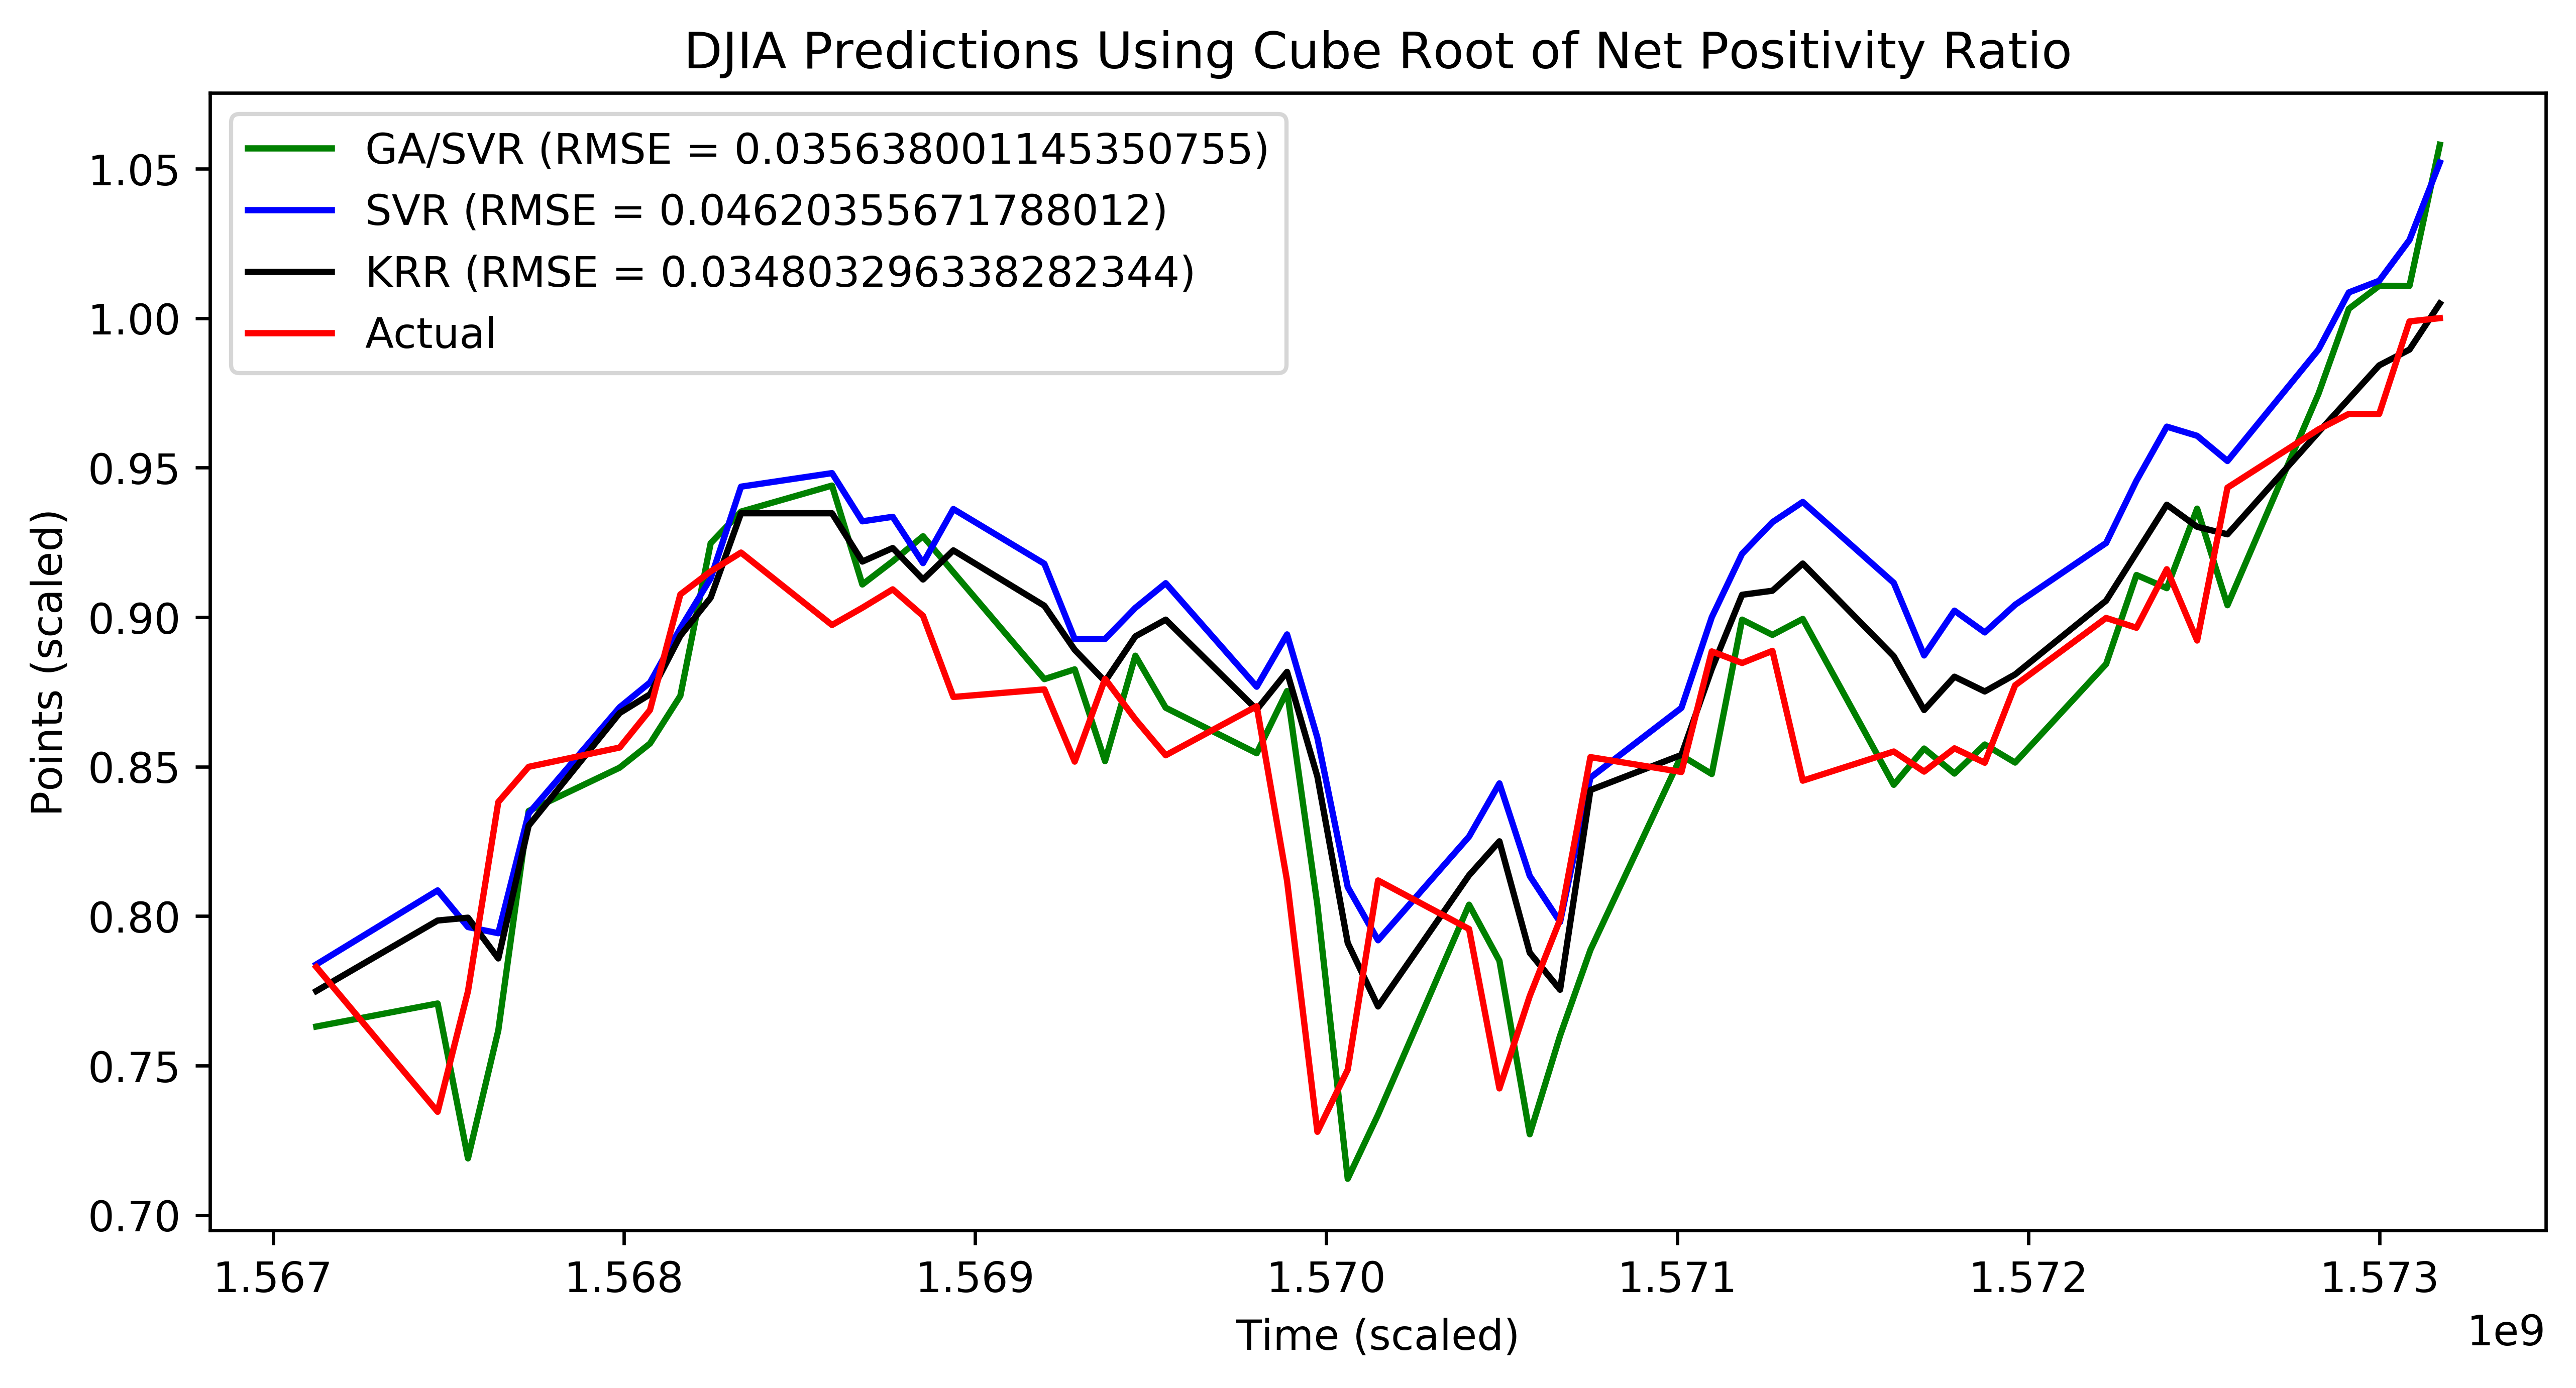

In [5]:

news_stat_ratio_2 = {}
for k, v in news_stat.items():
    news_stat_ratio_2[k] = [news_stat[k][0], ((news_stat[k][1] - news_stat[k][2]) / (news_stat[k][0]) ** 1/3)]
    
inp3 = dict_zip(djia_stat, news_stat_ratio_2)
split, actual, res3, resga3, res_mk3 = fit(inp3)
xs = [x[0] for x in inp3[split:]]
plt.plot(xs, resga3, "g", label="GA/SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, resga3))) + ")")
plt.plot(xs, res3, "b", label="SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res3))) + ")")
plt.plot(xs, res_mk3, "k", label="KRR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res_mk3))) + ")")
plt.plot(xs, actual, "r", label="Actual")
plt.title("DJIA Predictions Using Cube Root of Net Positivity Ratio")
plt.xlabel('Time (scaled)')
plt.ylabel('Points (scaled)')
plt.legend()

In [6]:
control = {}
for k, v in news_stat.items():
    control[k] = []
    
inp4 = dict_zip(djia_stat, control)
split, actual, res4, resga4, res_mk4 = fit(inp4)
xs = [x[0] for x in inp4[split:]]

[LibSVM]Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min              	max                      
0  	1000  	[-1340.01128449     1.473     ]	[3.40651872e+03 8.60970964e-01]	[-10000.      0.]	[-0.00860168  3.        ]
1  	575   	[-130.0098188    1.73     ]    	[1.13273891e+03 7.30136973e-01]	[-10000.      0.]	[-0.00860168  3.        ]
2  	586   	[-50.00887124   1.341     ]    	[7.05336170e+02 5.73340213e-01]	[-10000.      0.]	[-0.00860168  3.        ]
3  	589   	[-100.00855633    1.031     ]  	[9.94986577e+02 2.23693987e-01]	[-10000.      0.]	[-0.00860168  2.        ]
4  	599   	[-100.00855406    1.002     ]  	[9.94986577e+02 1.48310485e-01]	[-10000.      0.]	[-0.00860168  2.        ]
5  	588   	[-120.00852265    1.007     ]  	[1.08885167e+03 1.75928963e-01]	[-10000.      0.]	[-0.00860168  2.        ]
6  	635   	[-120.00854018    1.002     ]  	[1.08885167e+03 1.67320053e-01]	[-10000.      0.]	[-0.00860168  3.       

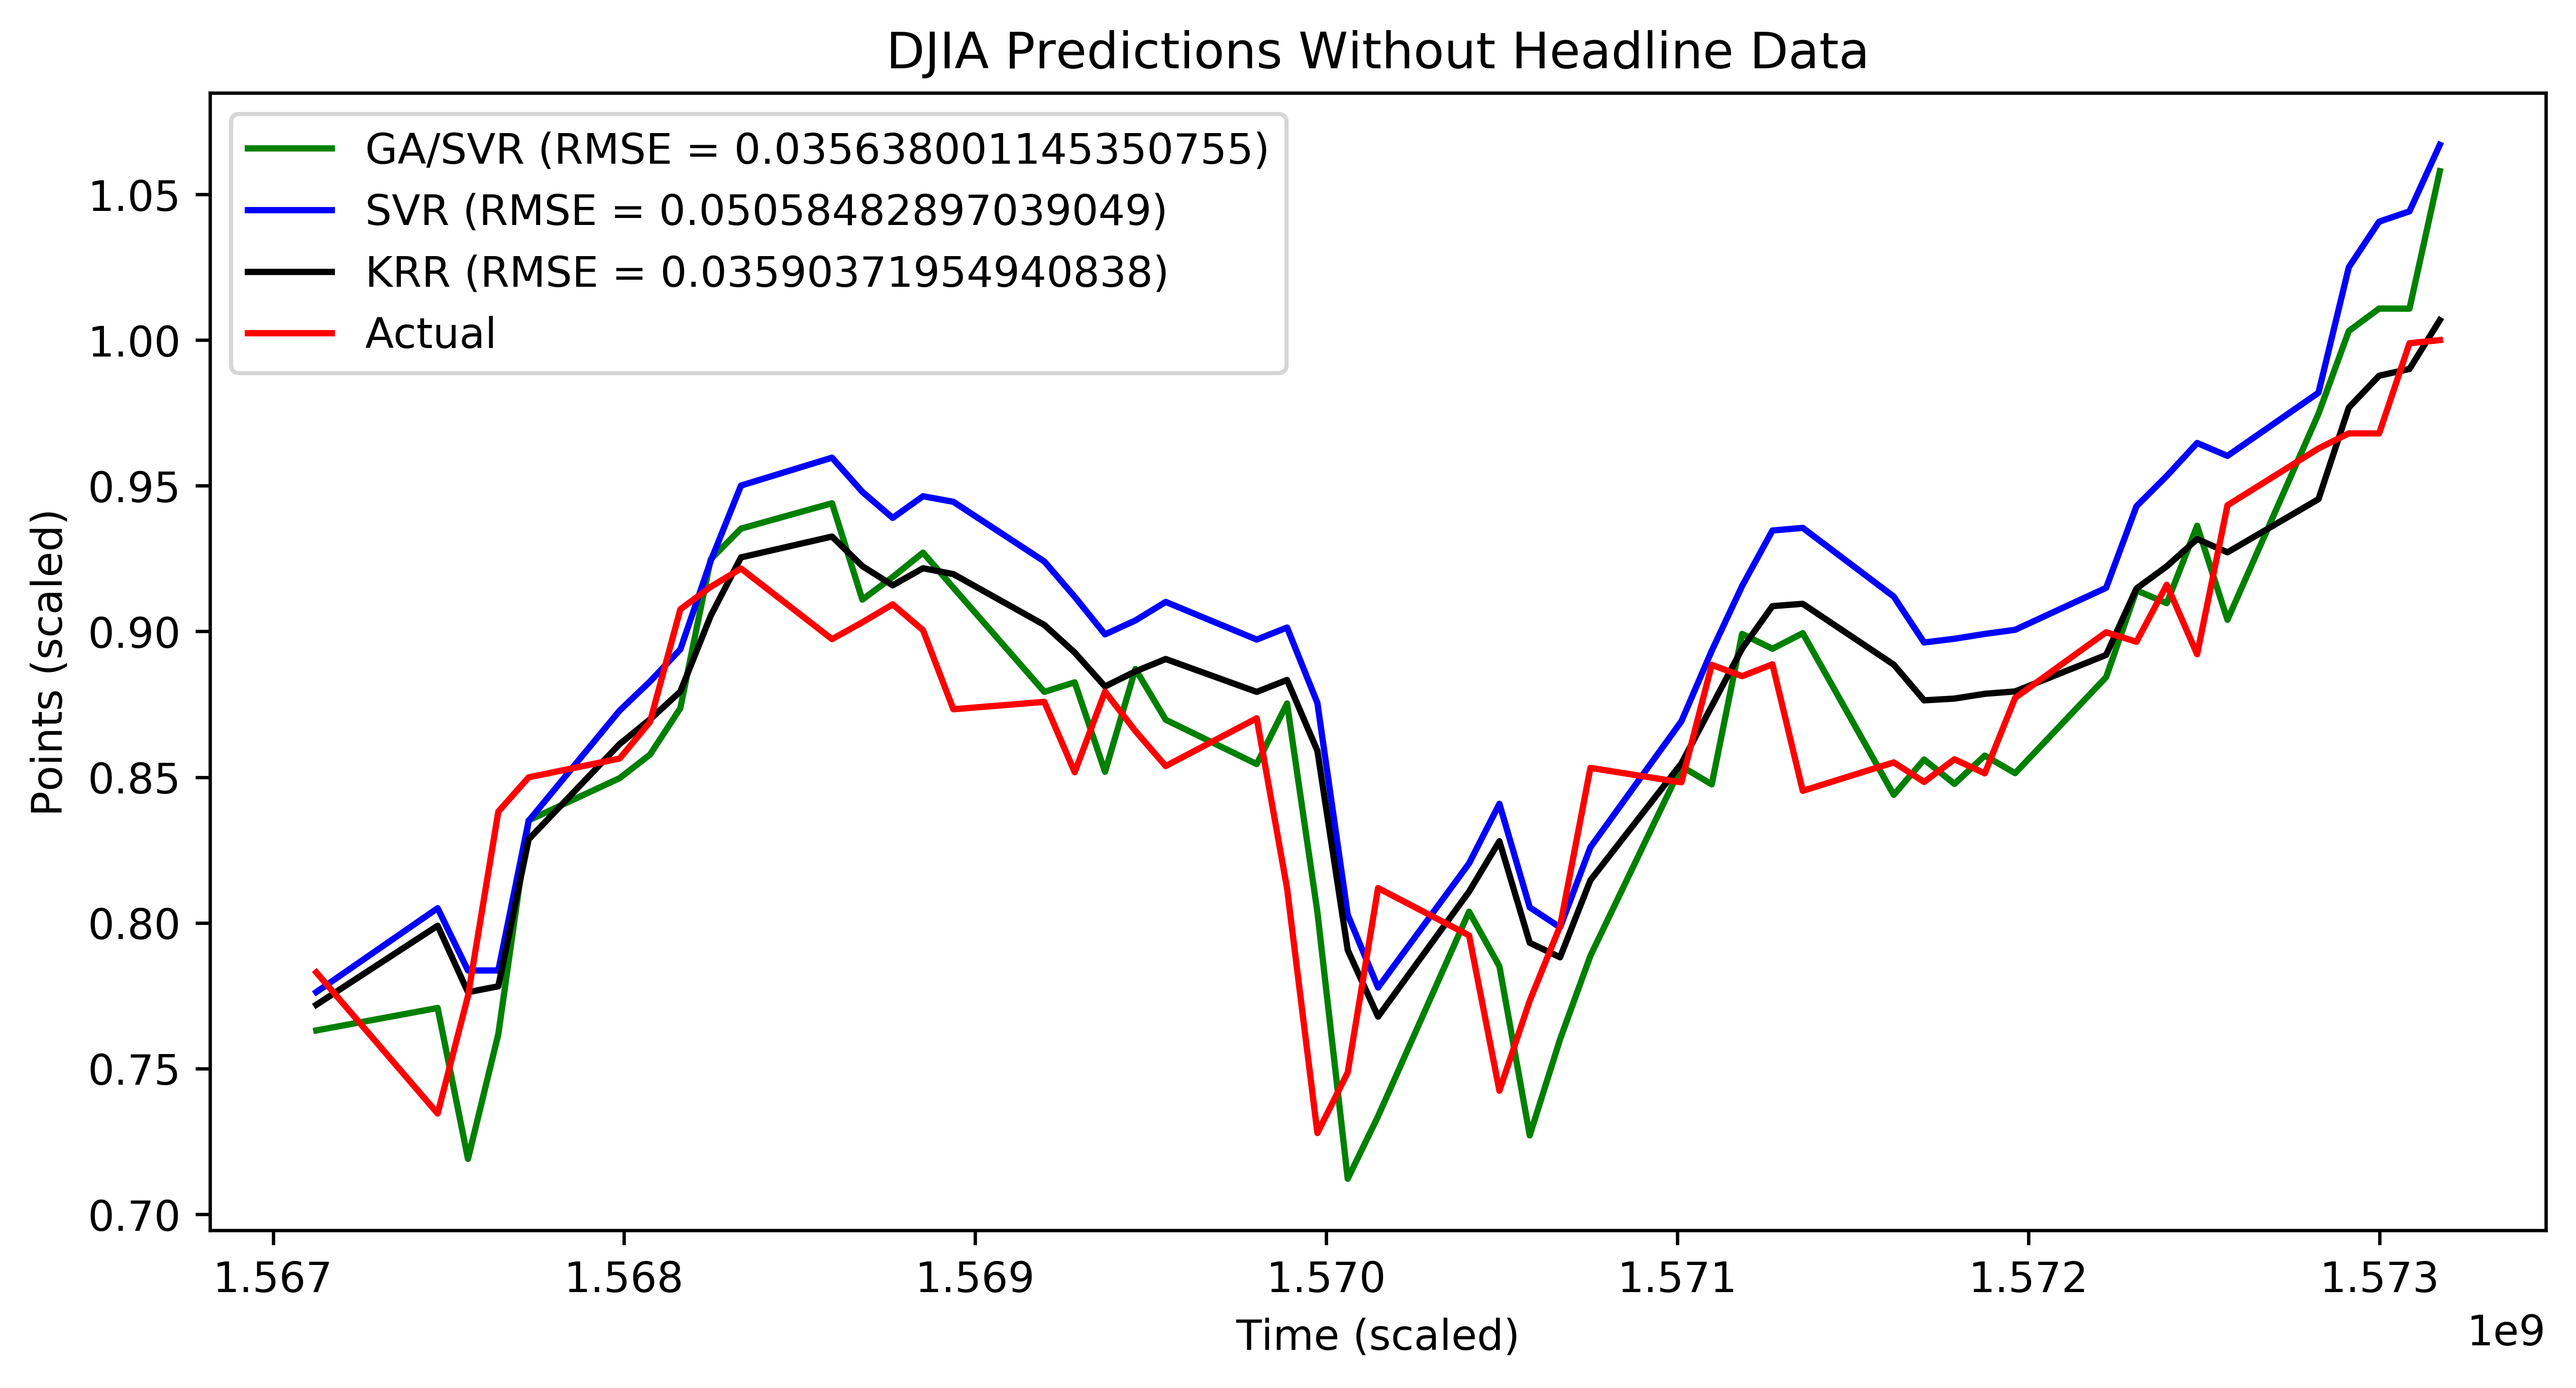

In [7]:
plt.plot(xs, resga4, "g", label="GA/SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, resga4))) + ")")
plt.plot(xs, res4, "b", label="SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res4))) + ")")
plt.plot(xs, res_mk4, "k", label="KRR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res_mk4))) + ")")
plt.plot(xs, actual, "r", label="Actual")
plt.title("DJIA Predictions Without Headline Data")
plt.xlabel('Time (scaled)')
plt.ylabel('Points (scaled)')
plt.legend()

[LibSVM]Selecting features with genetic algorithm.
gen	nevals	avg                          	std                            	min              	max                      
0  	1000  	[-400.02181784    2.428     ]	[1.95958734e+03 1.14228543e+00]	[-10000.      0.]	[-0.00875163  5.        ]
1  	577   	[-100.01537794    2.499     ]	[994.98589158   1.03150327]    	[-10000.      0.]	[-0.00875163  5.        ]
2  	627   	[-100.01139846    2.061     ]	[9.94986292e+02 8.95141888e-01]	[-10000.      0.]	[-0.00875163  5.        ]
3  	567   	[-80.0094832   1.6      ]    	[8.90841446e+02 6.88476579e-01]	[-10000.      0.]	[-0.00875163  5.        ]
4  	604   	[-70.00903151   1.19      ]  	[8.33725816e+02 4.31161223e-01]	[-10000.      0.]	[-0.00875163  3.        ]
5  	546   	[-60.00895181   1.032     ]  	[7.72268688e+02 2.21305219e-01]	[-10000.      0.]	[-0.00875163  3.        ]
6  	606   	[-80.00910463   1.035     ]  	[8.90841480e+02 2.44489264e-01]	[-10000.      0.]	[-0.00875163  3.        ]
7  	615   	[-

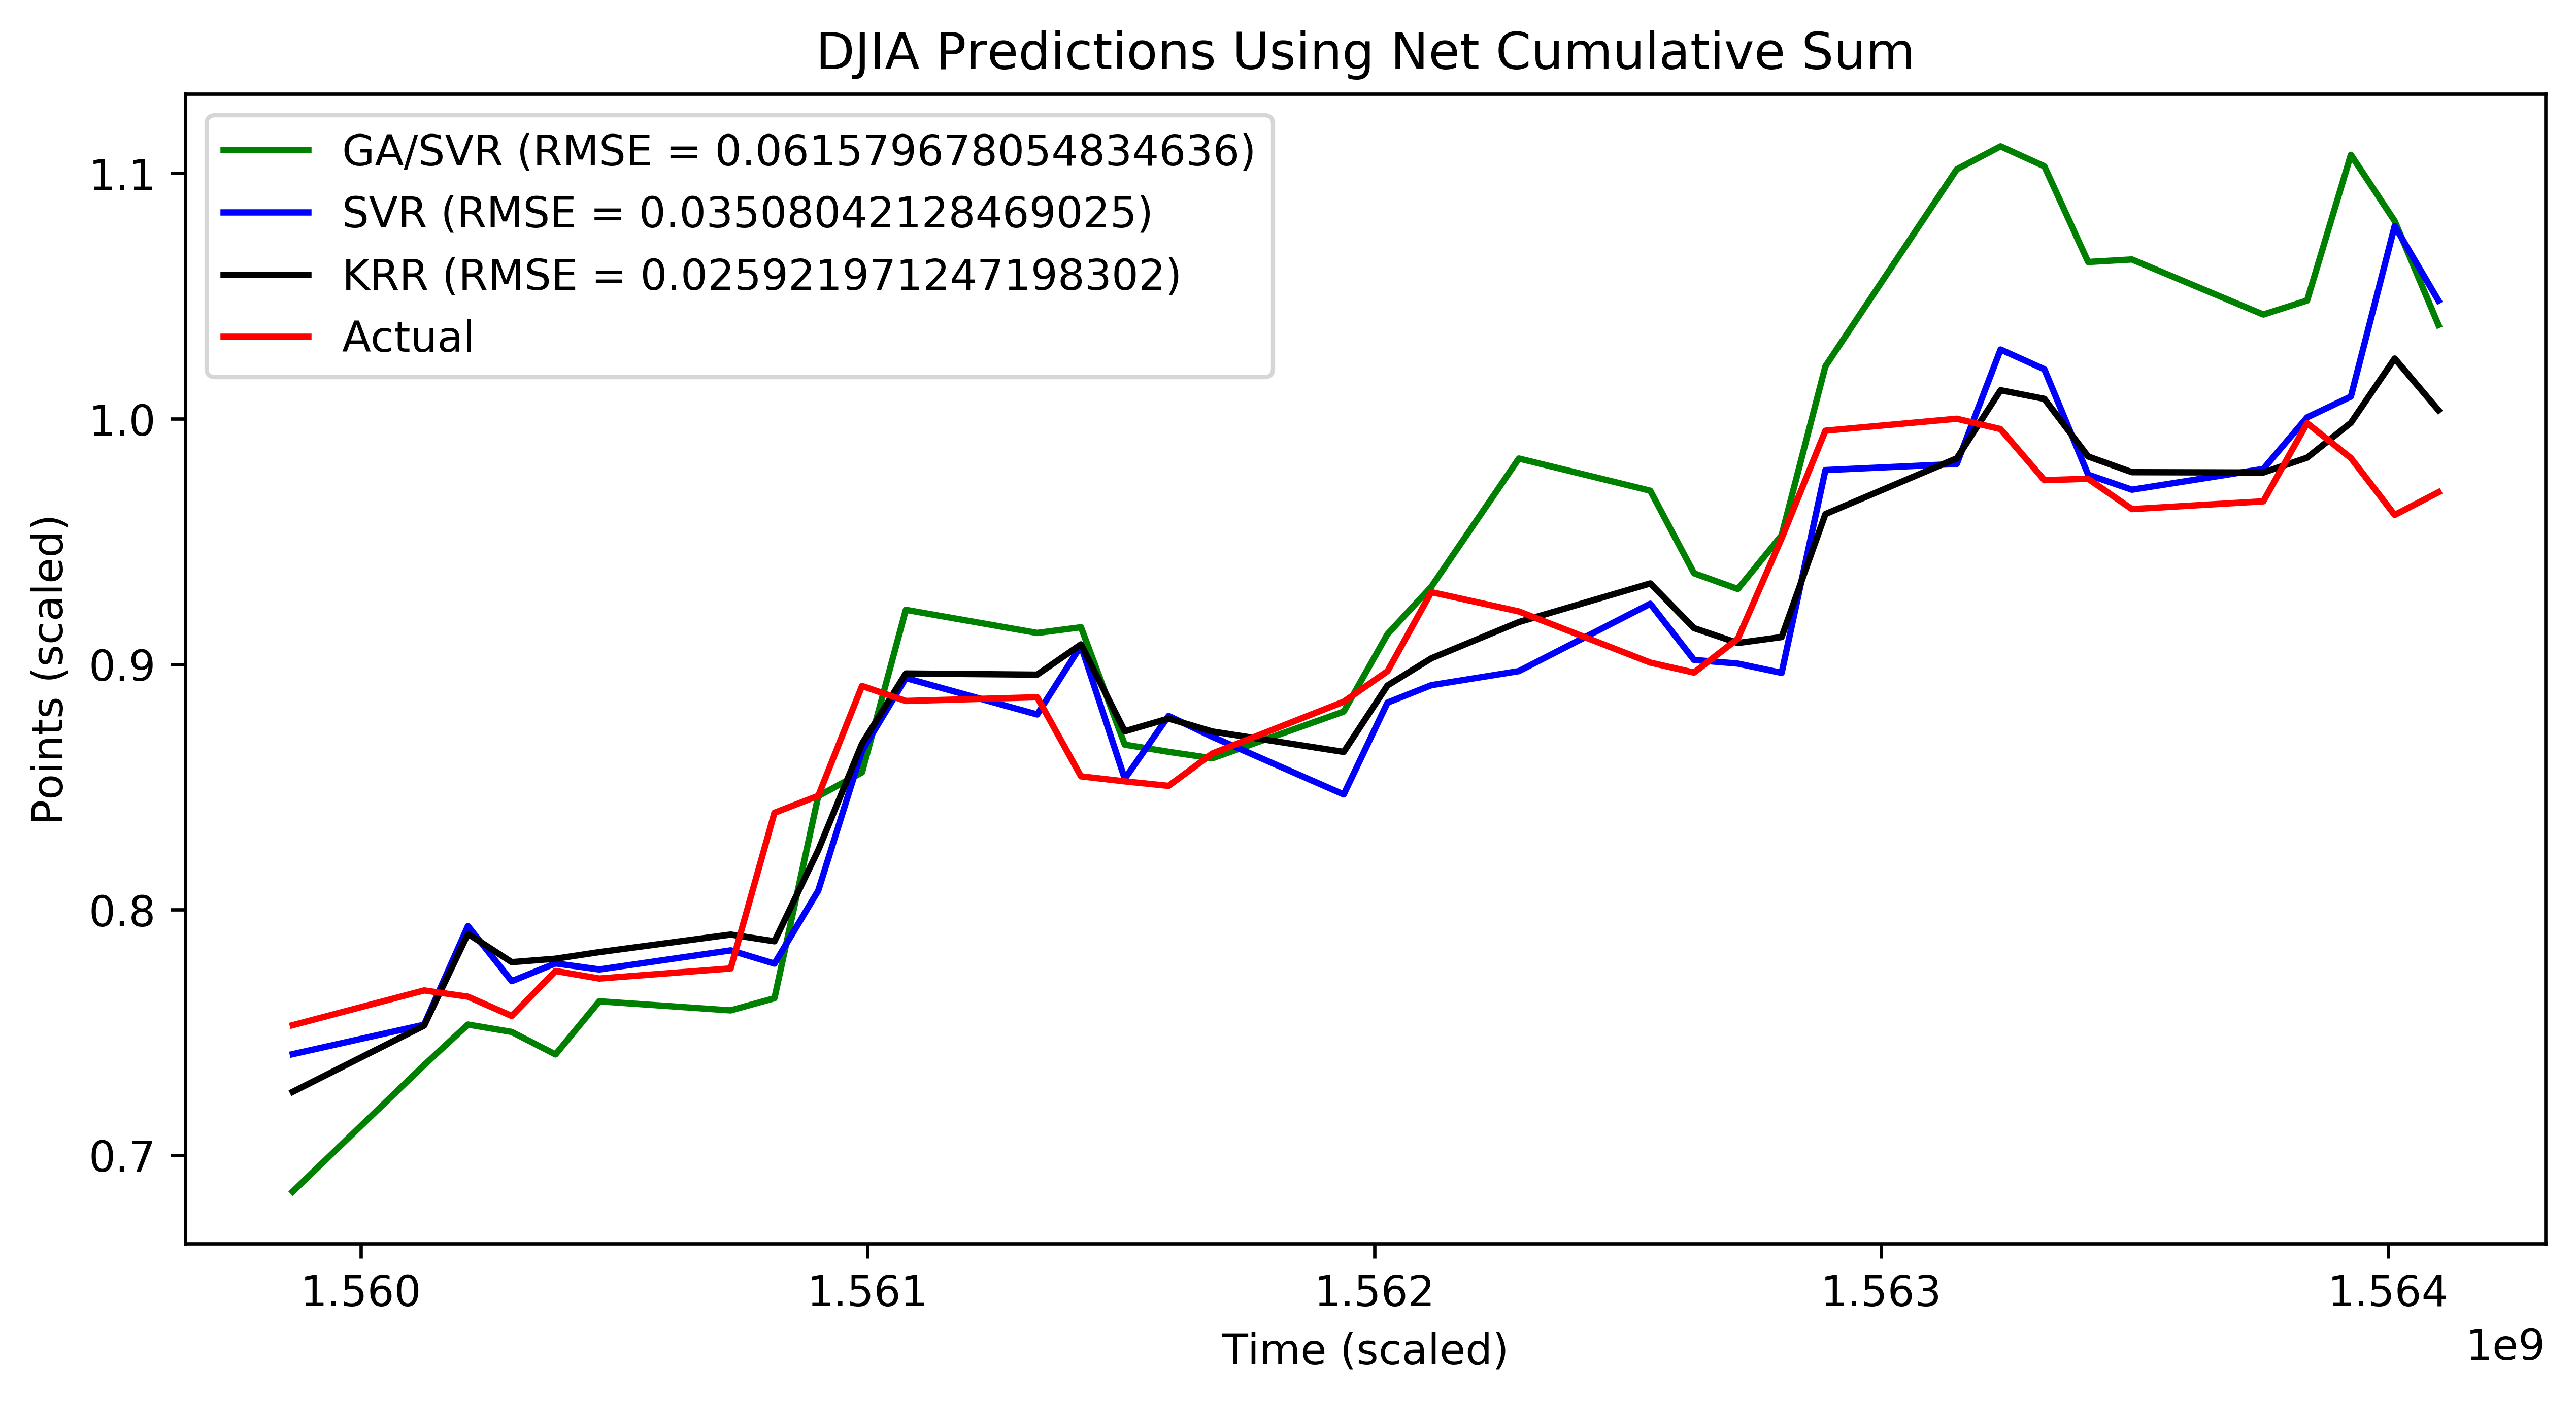

In [12]:
possum = np.cumsum([x[1] for k, x in news_stat.items() if k in djia_stat.keys()])
negsum = np.cumsum([x[2] for k, x in news_stat.items() if k in djia_stat.keys()])
netsum = possum - negsum
netsum_dict = {}
djia_stat_fixed = {}
for k, v in netsum_dict:
    if k in djia_stat.keys():
        djia_stat_fixed[k] = djia_stat[k]

for k, v in zip(news_stat.keys(), netsum):
    netsum_dict[k] = [news_stat[k][0], v]
    
inp5 = dict_zip(djia_stat, netsum_dict)
split, actual, res5, resga5, res_mk5 = fit(inp5)
xs = [x[0] for x in inp5[split:]]
plt.plot(xs, resga5, "g", label="GA/SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, resga5))) + ")")
plt.plot(xs, res5, "b", label="SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res5))) + ")")
plt.plot(xs, res_mk5, "k", label="KRR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res_mk5))) + ")")
plt.plot(xs, actual, "r", label="Actual")
plt.title("DJIA Predictions Using Net Cumulative Sum")
plt.xlabel('Time (scaled)')
plt.ylabel('Points (scaled)')
plt.legend()

In [9]:
print(len(djia_stat.keys()), len(news_stat.keys()))
print([x for x in djia_stat.keys() if x not in news_stat.keys()]) # Apparently Nov 23 and Jan 23 both cause issues?

250 344
[1542931200.0, 1548201600.0]
